# Forecasting the Breeding Bird Survey

In [65]:
library(forecast)
library(Hmisc)
library(dplyr)
library(broom)
library(MODISTools)
library(ggplot2)
library(wesanderson)
library(RColorBrewer)
library(tidyr)
source("forecast-bbs-core.R")

ERROR: Error in library(wesanderson): there is no package called ‘wesanderson’


## Initial data setup

Load the BBS data and limit it to sites with contiguous time-series from 2000 to 2014 (the range spanned by the MODIS data).

In [2]:
data <- get_bbs_data()
data <- filter(data, (site_id %/% 1000) != 3) # Drop Alaska from analysis
min_ts_length <- 20
contig_ts_long <- get_filtered_ts(data, min_ts_length = min_ts_length)
head(contig_ts_long)

Joining by: "site_id"


,site_id,lat,long,year,species_id,abundance
1,2007,34.86804,-86.20304,1974,2010,1
2,2007,34.86804,-86.20304,1974,2730,4
3,2007,34.86804,-86.20304,1974,2890,24
4,2007,34.86804,-86.20304,1974,3131,2
5,2007,34.86804,-86.20304,1974,3160,48
6,2007,34.86804,-86.20304,1974,3250,10


## Extract the richness time-series

In [3]:
data_by_site_yr <- group_by(contig_ts_long, site_id, year)
richness <- summarise(data_by_site_yr, richness = n_distinct(species_id))
head(richness)

,site_id,year,richness
1,2007,1974,52
2,2007,1978,55
3,2007,1979,59
4,2007,1980,54
5,2007,1981,56
6,2007,1982,44


In [4]:
richness_by_site <- group_by(richness, site_id)
cat("There are", n_groups(richness_by_site), "continuous time-series with at least" , min_ts_length, "years of data")

There are 888 continuous time-series with at least 20 years of data

## NDVI time-series data

In [68]:
data_modern <- filter(data, year >= 2000)
contig_ts_long_modern <- get_filtered_ts(data_modern, min_ts_length = 15)
richness_w_ndvi <- get_ndvi_ts_data(contig_ts_long_modern, modis_data_location = "./data/modisdata/")
head(richness_w_ndvi)
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)

Joining by: "site_id"


,site_id,lat,long,year,richness,start.date,end.date,SubsetID,ndvi
1,2001,34.86869,-87.60414,2000,61,2000-06-01,2000-06-30,Lat34.86869Lon-87.60414Start2000-06-01End2000-06-30,0.74035
2,2001,34.86869,-87.60414,2001,58,2001-06-01,2001-06-30,Lat34.86869Lon-87.60414Start2001-06-01End2001-06-30,0.76325
3,2001,34.86869,-87.60414,2002,61,2002-06-01,2002-06-30,Lat34.86869Lon-87.60414Start2002-06-01End2002-06-30,0.77125
4,2001,34.86869,-87.60414,2003,66,2003-06-01,2003-06-30,Lat34.86869Lon-87.60414Start2003-06-01End2003-06-30,0.7454
5,2001,34.86869,-87.60414,2004,62,2004-06-01,2004-06-30,Lat34.86869Lon-87.60414Start2004-06-01End2004-06-30,0.802
6,2001,34.86869,-87.60414,2005,59,2005-06-01,2005-06-30,Lat34.86869Lon-87.60414Start2005-06-01End2005-06-30,0.77445


## Forecasting

Generate forecasts for naive, average, and ARIMA time-series models for each site.

In [7]:
lag <- 5
tsmodel_forecasts <- get_ts_forecasts(richness_by_site, timecol = 'year',
                                      responsecol = 'richness', lag = lag)
tsmodel_forecasts_modern <- get_ts_forecasts(richness_w_ndvi_by_site,
                                             timecol = 'year',
                                             responsecol = 'richness',
                                             lag = lag)
head(tsmodel_forecasts_modern, 1)

,site_id,year,cast_naive,cast_avg,cast_arima,test_set
1,2001,"2010, 2011, 2012, 2013, 2014","Naive method, 12.75, -21.53363, 45.06727, 0, 0, 0, 0, 1, 1, 0, 0.06099997, -3, 3, 5, -4, -3, 5, 0, -3, Arima(x = x, order = c(0, 1, 0), lambda = lambda), x, 0, 0, 8, 1, 1, 1, -3, 64, 0, -7.420876e-23, -7.420876e-23, 7.420876e-23, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 7.420876e-23, 45.73393, 45.14671, 61, 58, 61, 66, 62, 59, 64, 64, 61, 80, 95, 61, 61, 61, 61, 61, 56.42395, 54.52848, 53.07404, 51.84789, 50.76763, 54.00153, 51.10267, 48.87829, 47.00306, 45.35094, 65.57605, 67.47152, 68.92596, 70.15211, 71.23237, 67.99847, 70.89733, 73.12171, 74.99694, 76.64906, 61, 58, 61, 66, 62, 59, 64, 64, 61, structure(c(61L, 58L, 61L, 66L, 62L, 59L, 64L, 64L, 61L), .Tsp = c(1, , 9, 1), class = ""ts""), NA, 61, 58, 61, 66, 62, 59, 64, 64, NA, -3, 3, 5, -4, -3, 5, 0, -3","Mean, 80, 95, 61, 58, 61, 66, 62, 59, 64, 64, 61, .[[responsecol]][1:(length(.[[responsecol]]) - lag - 1)], 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 58.04003, 58.04003, 58.04003, 58.04003, 58.04003, 55.60712, 55.60712, 55.60712, 55.60712, 55.60712, 65.51553, 65.51553, 65.51553, 65.51553, 65.51553, 67.94844, 67.94844, 67.94844, 67.94844, 67.94844, 61.77778, 0.846197, 2.538591, meanf(x = .[[responsecol]][1:(length(.[[responsecol]]) - lag - , 1)], h = lag), 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, -0.7777778, -3.777778, -0.7777778, 4.222222, 0.2222222, -2.777778, 2.222222, 2.222222, -0.7777778","ARIMA(0,0,0) with non-zero mean, 61.77778, 5.728395, 0.6364964, TRUE, -20.62491, 45.24981, 0, 0, 0, 0, 1, 0, 0, -0.7777778, -3.777778, -0.7777778, 4.222222, 0.2222222, -2.777778, 2.222222, 2.222222, -0.7777778, auto.arima(x = structure(list(x = structure(c(61L, 58L, 61L, , 66L, 62L, 59L, 64L, 64L, 61L), .Tsp = c(1, 9, 1), class = ""ts"")), .Names = ""x"", row.names = c(NA, , -9L), class = ""data.frame""), seasonal = FALSE), .[[responsecol]][1:(length(.[[responsecol]]) - lag - 1)], 0, 0, 9, 1, -0.7777778, 0, 0, 1, 0, 1, 45.64426, 47.24981, 61, 58, 61, 66, 62, 59, 64, 64, 61, 80, 95, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 58.7105, 58.7105, 58.7105, 58.7105, 58.7105, 57.08679, 57.08679, 57.08679, 57.08679, 57.08679, 64.84505, 64.84505, 64.84505, 64.84505, 64.84505, 66.46877, 66.46877, 66.46877, 66.46877, 66.46877, 61, 58, 61, 66, 62, 59, 64, 64, 61, structure(c(61L, 58L, 61L, 66L, 62L, 59L, 64L, 64L, 61L), .Tsp = c(1, , 9, 1), class = ""ts""), 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, 61.77778, -0.7777778, -3.777778, -0.7777778, 4.222222, 0.2222222, -2.777778, 2.222222, 2.222222, -0.7777778","61, 69, 59, 69, 69"


## NDVI based forecasting


Call:
lm(formula = meanrich ~ meanndvi, data = richness_w_ndvi_site_avg)

Residuals:
    Min      1Q  Median      3Q     Max 
-39.430  -6.793   0.092   6.302  42.189 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   31.725      1.577   20.12   <2e-16 ***
meanndvi      39.132      2.328   16.81   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.53 on 628 degrees of freedom
  (6 observations deleted due to missingness)
Multiple R-squared:  0.3102,	Adjusted R-squared:  0.3091 
F-statistic: 282.4 on 1 and 628 DF,  p-value: < 2.2e-16


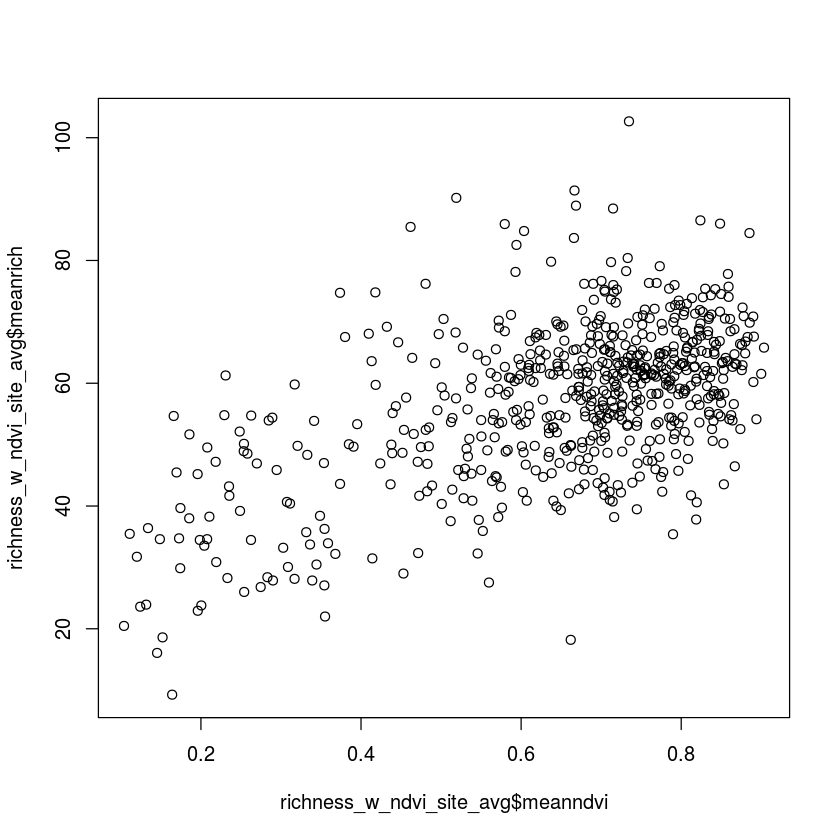

In [69]:
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)
richness_w_ndvi_site_avg <- summarize(richness_w_ndvi_by_site, meanrich = mean(richness), meanndvi = mean(ndvi))
summary(lm(meanrich ~ meanndvi, data = richness_w_ndvi_site_avg))
plot(richness_w_ndvi_site_avg$meanndvi, richness_w_ndvi_site_avg$meanrich)

In [70]:
richness_w_ndvi_by_year <- group_by(richness_w_ndvi, year)
results <- richness_w_ndvi_by_year %>%
           do(fitndvi = lm(richness ~ ndvi, data = .))
ndvi_spatial_models <- tidy(results, fitndvi)
ndvi_spatial_fits <- glance(results, fitndvi)

## Spatial NDVI model prediction

In [71]:
richness_w_ndvi_2008 <- filter(richness_w_ndvi, year == 2008)
richness_w_ndvi_2009 <- filter(richness_w_ndvi, year == 2009)
richness_w_ndvi_2009 <- cbind(richness_w_ndvi_2009, last_yr_rich = richness_w_ndvi_2008$richness)
richness_w_ndvi_2010_2014 <- filter(richness_w_ndvi, year >= 2010)
spatial_ndvi_model_2009 <- lm(richness ~ ndvi, data = richness_w_ndvi_2009)
fcast_spatial_ndvi <- forecast(spatial_ndvi_model_2009, newdata=richness_w_ndvi_2010_2014)
fcast_spatial_ndvi_data <- cbind(richness_w_ndvi_2010_2014, fcast_spatial_ndvi)
fcast_spatial_ndvi <- fcast_spatial_ndvi_data[, c("site_id", "year", "richness", "Point Forecast", "Lo 80", "Hi 80", "Lo 95", "Hi 95")]
colnames(fcast_spatial_ndvi) <- c("site_id", "year", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
fcast_spatial_ndvi$model <- 'spat_ndvi'
fcast_spatial_ndvi <- select(fcast_spatial_ndvi, site_id, model, everything())
head(fcast_spatial_ndvi)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,spat_ndvi,2010,61,60.14135,44.63397,75.64874,36.40422,83.87849
2,2001,spat_ndvi,2011,69,61.42931,45.91947,76.93914,37.68842,85.17019
3,2001,spat_ndvi,2012,59,56.51739,41.0114,72.02339,32.78238,80.25241
4,2001,spat_ndvi,2013,69,62.97417,47.46004,78.4883,39.2267,86.72163
5,2001,spat_ndvi,2014,69,59.36892,43.86252,74.87533,35.63329,83.10456
6,2021,spat_ndvi,2010,41,62.17281,46.66109,77.68453,38.42905,85.91658


## Temporal NDVI model prediction

In [72]:
richness_w_ndvi_by_site <- group_by(richness_w_ndvi, site_id)
fcast_temporal_ndvi_data <- richness_w_ndvi_by_site %>% do({
                            trainset <- filter(., year < 2010)
                            testset <- filter(., year >= 2010)
                            fitndvi <- lm(richness ~ ndvi, data = trainset)
                            fitndvi$data <- trainset # see http://stackoverflow.com/questions/31399605/passing-data-to-forecast-lm-using-dplyr-and-do
                            data.frame(testset[], fcast = forecast(fitndvi, newdata = testset))})
fcast_temporal_ndvi <- fcast_temporal_ndvi_data[, c("site_id", "year", "richness", "fcast.Point.Forecast", "fcast.Lo.80", "fcast.Hi.80", "fcast.Lo.95", "fcast.Hi.95")]
colnames(fcast_temporal_ndvi) <- c("site_id", "year", "obs", "pt_fcast", "lo80", "hi80", "lo95", "hi95")
fcast_temporal_ndvi$model <- 'temporal_ndvi'
fcast_temporal_ndvi <- select(fcast_temporal_ndvi, site_id, model, everything())
head(fcast_temporal_ndvi)

Warning message:
In qt((1 - level)/2, df): NaNs producedWarning message:
In qt((1 - level)/2, df): NaNs produced

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,temporal_ndvi,2010,61,63.04169,59.22985,66.85352,56.74872,69.33465
2,2001,temporal_ndvi,2011,69,61.30478,57.73965,64.86991,55.4191,67.19046
3,2001,temporal_ndvi,2012,59,67.92888,61.48022,74.37755,57.28277,78.57499
4,2001,temporal_ndvi,2013,69,59.22141,55.23145,63.21138,52.63437,65.80845
5,2001,temporal_ndvi,2014,69,64.08337,59.8902,68.27654,57.16086,71.00588
6,2021,temporal_ndvi,2010,41,49.70271,39.13351,60.27192,32.254,67.15143


## Example single site forecast

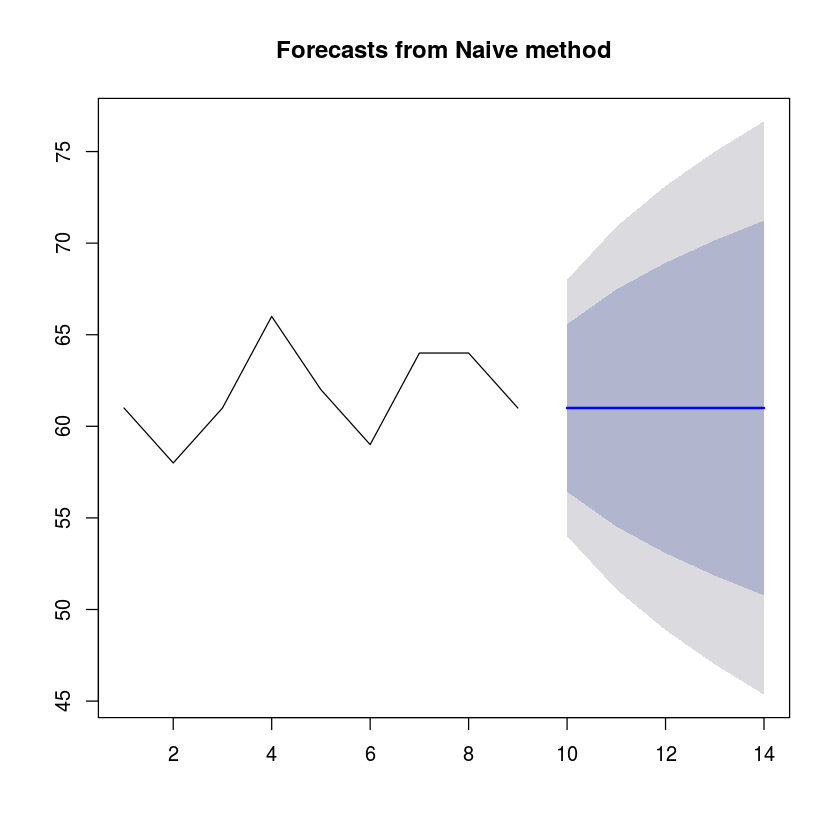

In [38]:
sites <- unique(richness_w_ndvi$site_id)
focal_site <- sites[1]
ts_forecasts_focal <- filter(tsmodel_forecasts_modern, site_id == focal_site)
plot(ts_forecasts_focal$cast_naive[[1]])


## Assembling forecasts from different approaches

In [12]:
tsmodel_out <- tsmodel_forecasts_modern %>%
                        do(
                           {year <- as.data.frame(.$year)
                            colnames(year) <- c('year')
                            naive <- as.data.frame(.$cast_naive)
                            colnames(naive) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            naive <- cbind(year, naive)
                            naive$model <- 'naive'
                            naive$site_id <- .$site
                            naive$obs <- .$test_set
                            avg <- as.data.frame(.$cast_avg)
                            colnames(avg) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            avg <-cbind(year, avg)
                            avg$model <- 'avg'
                            avg$site_id <- .$site
                            avg$obs <- .$test_set
                            arima <- as.data.frame(.$cast_arima)
                            colnames(arima) <- c('pt_fcast', 'lo80', 'hi80', 'lo95', 'hi95')
                            arima <- cbind(year, arima)
                            arima$model <- 'arima'
                            arima$site_id <- .$site
                            arima$obs <- .$test_set
                            df <- rbind(naive, avg, arima)
                            df %>% select(site_id, model, year, obs, everything())
                           }
                          )
head(tsmodel_out)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,naive,2010,61,61,56.42395,65.57605,54.00153,67.99847
2,2001,naive,2011,69,61,54.52848,67.47152,51.10267,70.89733
3,2001,naive,2012,59,61,53.07404,68.92596,48.87829,73.12171
4,2001,naive,2013,69,61,51.84789,70.15211,47.00306,74.99694
5,2001,naive,2014,69,61,50.76763,71.23237,45.35094,76.64906
6,2001,avg,2010,61,61.77778,58.04003,65.51553,55.60712,67.94844


In [73]:
forecasts <- rbind(tsmodel_out, fcast_temporal_ndvi, fcast_spatial_ndvi)
head(forecasts)

,site_id,model,year,obs,pt_fcast,lo80,hi80,lo95,hi95
1,2001,naive,2010,61,61,56.42395,65.57605,54.00153,67.99847
2,2001,naive,2011,69,61,54.52848,67.47152,51.10267,70.89733
3,2001,naive,2012,59,61,53.07404,68.92596,48.87829,73.12171
4,2001,naive,2013,69,61,51.84789,70.15211,47.00306,74.99694
5,2001,naive,2014,69,61,50.76763,71.23237,45.35094,76.64906
6,2001,avg,2010,61,61.77778,58.04003,65.51553,55.60712,67.94844


In [74]:
model_accuracies <- group_by(forecasts, site_id, model) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies)

Warning message:
: Grouping rowwise data frame strips rowwise nature

,site_id,model,ME,RMSE,MAE,MPE,MAPE
1,2001,arima,3.622222,5.741123,5.044444,5.083565,7.476822
2,2001,avg,3.622222,5.741123,5.044444,5.083565,7.476822
3,2001,naive,4.4,6.26099,5.2,6.278556,7.634488
4,2001,spat_ndvi,5.31377,6.217463,5.31377,7.855722,7.855722
5,2001,temporal_ndvi,2.283974,7.25126,6.672201,2.793837,10.18613
6,2021,arima,0.075,3.974528,3.525,-1.1517,9.858152


In [75]:
cbPalette <- c("#D55E00", "#E69F00", "#56B4E9", "#F0E442", "#009E73", "#0072B2", "#999999", "#CC79A7")
# rearranged from http://www.cookbook-r.com/Graphs/Colors_%28ggplot2%29/#a-colorblind-friendly-palette

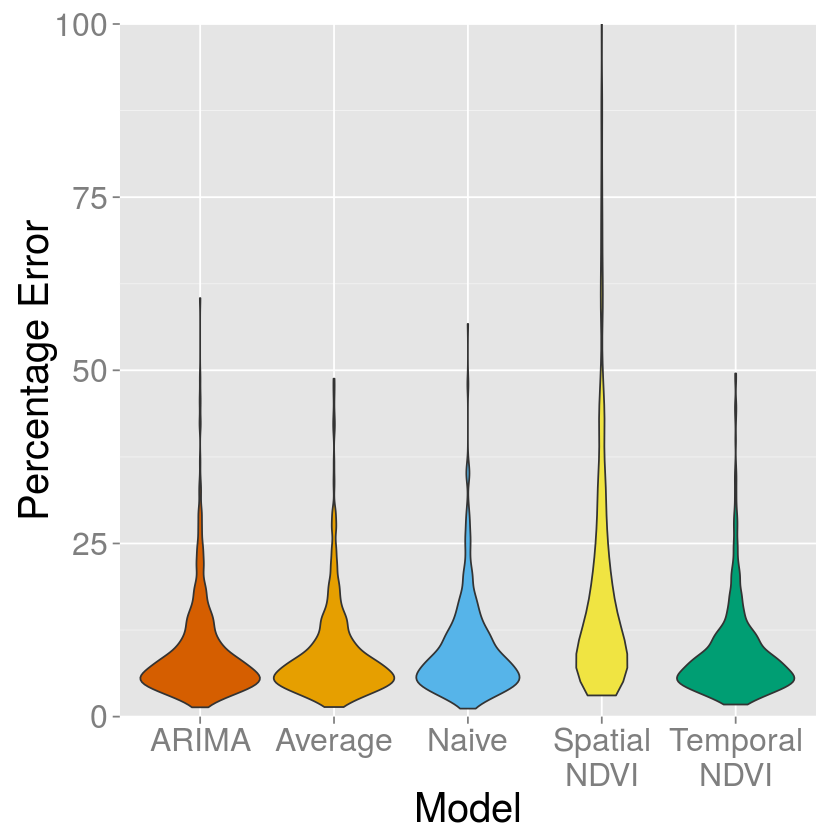

In [76]:
accuracy_by_model_violins <- ggplot(model_accuracies, aes(model, MAPE)) +
     geom_violin(aes(fill = model)) + coord_cartesian(ylim = c(0,100)) +
     labs(x = "Model", y = "Percentage Error") +
     scale_x_discrete(labels=c("ARIMA", "Average", "Naive", "Spatial\nNDVI", "Temporal\nNDVI")) +
     scale_fill_manual(values = cbPalette, c("ARIMA", "AVG", "NAIVE", "Spatial NDVI", "Temporal NDVI")) + 
     theme_grey(base_size = 24) +
     guides(fill=FALSE)
ggsave(accuracy_by_model_violins, file = 'accuracy_by_model_violins.png', width = 7, height = 5)
accuracy_by_model_violins

In [77]:
model_accuracies_by_year <- group_by(forecasts, site_id, model, year) %>%
                    do(get_error_measures(.$obs, .$pt_fcast))
head(model_accuracies_by_year)

Warning message:
: Grouping rowwise data frame strips rowwise nature

,site_id,model,year,ME,RMSE,MAE,MPE,MAPE
1,2001,arima,2010,-0.7777778,0.7777778,0.7777778,-1.275046,1.275046
2,2001,arima,2011,7.222222,7.222222,7.222222,10.46699,10.46699
3,2001,arima,2012,-2.777778,2.777778,2.777778,-4.708098,4.708098
4,2001,arima,2013,7.222222,7.222222,7.222222,10.46699,10.46699
5,2001,arima,2014,7.222222,7.222222,7.222222,10.46699,10.46699
6,2001,avg,2010,-0.7777778,0.7777778,0.7777778,-1.275046,1.275046


Warning message:
: Removed 16 rows containing missing values (stat_summary).Warning message:
: Removed 16 rows containing missing values (stat_summary).

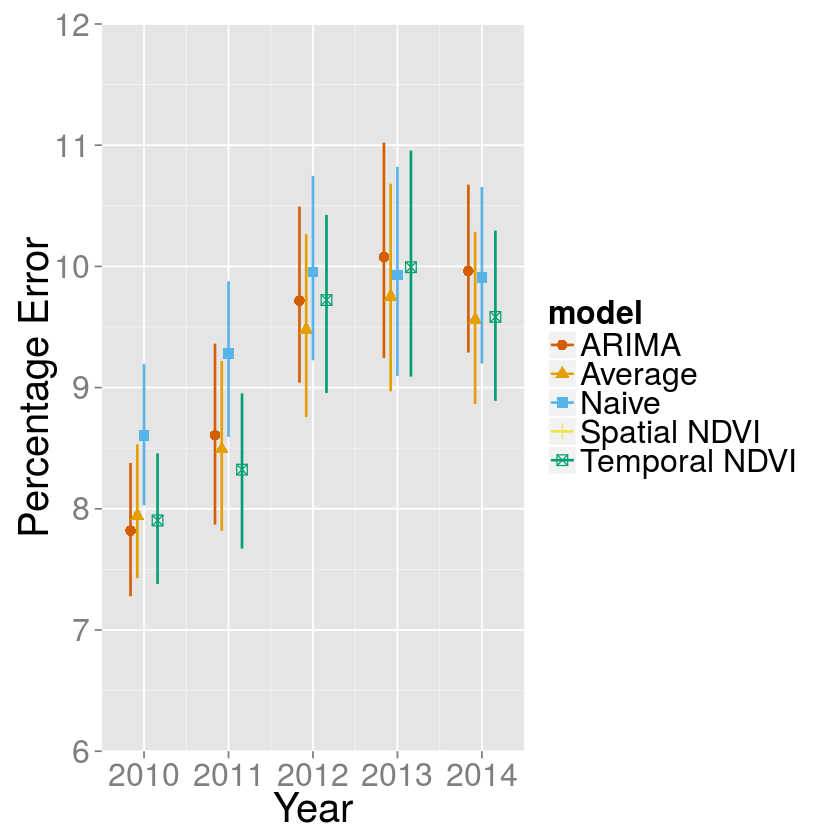

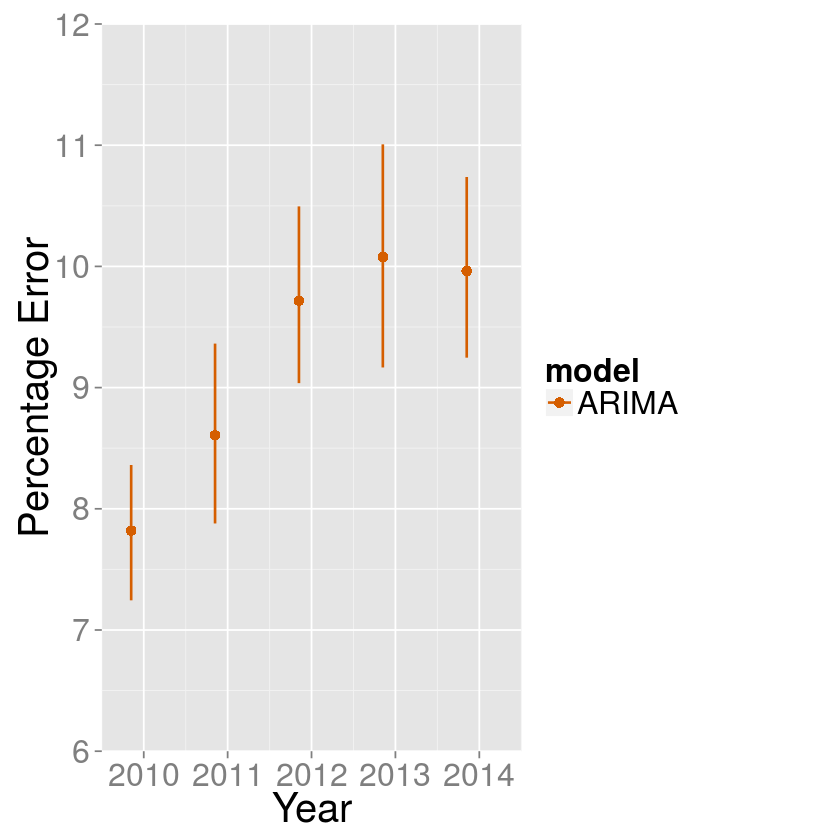

In [78]:
#ggplot(model_accuracies_by_year, aes(x = year, y = MAPE, color = model)) + stat_summary(fun.data = "mean_cl_boot")
model_accuracies_by_year_plot <- ggplot(model_accuracies_by_year, aes(x = year, y = MAPE, color = model, shape = model)) +
    stat_summary(fun.data = "mean_cl_boot", position=position_dodge(width = 0.4), size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(6,12), xlim = c(2009.5,2014.5)) +
     #scale_color_discrete(labels=c("ARIMA", "Average", "Naive", "Temporal NDVI")) +
     scale_shape_discrete(labels=c("ARIMA", "Average", "Naive", "Spatial NDVI", "Temporal NDVI")) +
     scale_color_manual(values = cbPalette, labels=c("ARIMA", "Average", "Naive", "Spatial NDVI", "Temporal NDVI")) + 
     theme_grey(base_size = 24)
     #theme(legend.justification=c(1,0), legend.position=c(1,0))
ggsave(model_accuracies_by_year_plot, file = "model_accuracies_by_year.png", height = 5, width = 7)

model_accuracies_by_year_arima_plot <- ggplot(filter(model_accuracies_by_year, model == 'arima'), aes(x = year - 0.15, y = MAPE, color = model, shape = model)) +
     stat_summary(fun.data = "mean_cl_boot", size=0.75) +
     labs(x = "Year", y = "Percentage Error") +
     coord_cartesian(ylim = c(6,12), xlim = c(2009.5,2014.5)) +
     scale_shape_discrete(labels=c("ARIMA             ")) +
     scale_color_manual(values = cbPalette, labels=c("ARIMA             ")) + 
     theme_grey(base_size = 24)

ggsave(model_accuracies_by_year_arima_plot, file = "arima_accuracies_by_year.png", height = 5, width = 7)

model_accuracies_by_year_plot
model_accuracies_by_year_arima_plot

[1] 2014

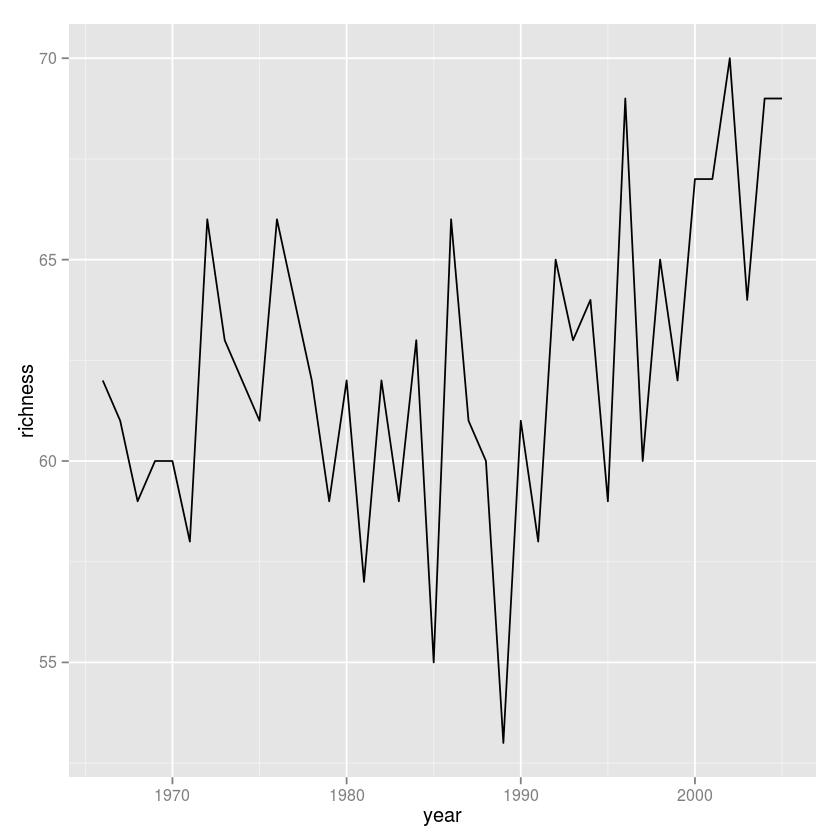

In [12]:
rich_site = filter(richness, site_id == unique(richness$site_id)[3])
ggplot(rich_site, aes(x = year, y = richness)) + geom_line()
unique(richness$site_id)[3]